In [1]:
import datajoint as dj

dj.config["database.host"] = "datajoint-public.internationalbrainlab.org"
dj.config["database.user"] = "ibl-public"
dj.config["database.password"] = "ibl-public" 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from nma_ibl import reference, subject, action, acquisition, data, behavior, behavior_analyses
from tools import length_last_streak, fetch_mice_by_percentage, search_sequence


[2022-07-26 21:09:42,816][INFO]: Connecting ibl-public@datajoint-public.internationalbrainlab.org:3306
[2022-07-26 21:09:45,309][INFO]: Connected ibl-public@datajoint-public.internationalbrainlab.org:3306


In [109]:
sns.set_style('whitegrid')

In [3]:
from nma_ibl import reference, subject, action, acquisition, data, behavior, behavior_analyses


## Method 1: One hot coding of streak lengths passed as features

In [16]:
def get_streak_data(lab,percentage,features):
  """ Returns streak of rewards and/or punishments before all trials with 50/50 probability, for all mice in chosen lab, with chosen training percentage.

  Parameters
  ----------    
  lab    : input string
  percentage    : input int
  features: input list of signed ints (positive for reward streak length, negative for punish streak length)

  Output
  ------    
  Output :
  2D array with size (features x samples)
  1D array with size samples
  """


  lab_mice_in_training = ((behavior_analyses.SessionTrainingStatus & {'training_status' : 'in_training'}) * subject.SubjectLab & {'lab_name' : lab}) & behavior.TrialSet.Trial
  lab_mice = np.unique(lab_mice_in_training.fetch('subject_uuid'))

  id = lab_mice_in_training.fetch('subject_uuid')
  training_days = np.zeros_like(lab_mice)

  for idx, mouse in enumerate(lab_mice):
    training_days[idx] = len(np.where(id == mouse)[0])

  dictionary = fetch_mice_by_percentage(lab_mice,lab_mice_in_training,percentage)


  X = np.empty((len(features)+1,1))
  
  y = []
  for mouse in lab_mice:
    try:
      for i in range(len(dictionary[mouse])):
        session, contrast_left, contrast_right = ((behavior.TrialSet.Trial & {'subject_uuid' : mouse} & {'trial_stim_prob_left': 0.5}) & {'session_start_time' : dictionary[mouse][i]}).fetch('trial_feedback_type','trial_stim_contrast_left','trial_stim_contrast_right')
        x_0 = contrast_left + contrast_right
        x = x_0

        for feature in features:
          x = np.vstack( (x,search_sequence(session,abs(feature), np.sign(feature) )))
        
        X = np.concatenate((X,x),axis=1)


        y = np.append(y,session)
    except:
      pass
    
  return(X[:,1:],y.astype('float'))

In [104]:
def streak_modelling(X,y):
    #  Splitting the dataset into train and test set
    x_train, x_test, y_train, y_test = train_test_split(X.T, y, test_size=0.25, random_state=0)

    # Normalizing the features before passing it to the model
    scaler = StandardScaler().fit(x_train)
    x_norm_train = scaler.transform(x_train)
    x_norm_test = scaler.transform(x_test)

    logisticRegr = LogisticRegression(class_weight='balanced')
    logisticRegr.fit(x_norm_train, y_train)
    coef = logisticRegr.coef_[0]

    y_pred = logisticRegr.predict(x_norm_test)

    #   Calculating accuracy of the model
    training_accuracy = logisticRegr.score(x_norm_train, y_train)
    test_accuracy = logisticRegr.score(x_norm_test, y_test)
    print("Training accuracy:{:.2f}  Test accuracy:{:.2f}".format(training_accuracy*100, test_accuracy*100))
    # print("Precision:{:.2f} Recall:{:.2f}".format(precision_score(y_pred, y_test)*100,
    #                                             recall_score(y_pred, y_test)*100))

    #   Calculating roc-auc of the model
    roc = roc_auc_score(y_test, y_pred)
    print("roc-auc score:{:.2f}".format(roc))
    print("Coefficients for logistic regression:")
    print(coef)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print("TN:{} FP:{} FN:{} TP:{}".format(tn, fp, fn, tp))
    return training_accuracy, test_accuracy, coef, roc

In [41]:
X, y = get_streak_data("mainenlab", 50, [4, 16, -4, -16])
# print(X.shape, y.shape)
train_acc, test_acc, coef = streak_modelling(X,y)

Training accuracy:72.48  Test accuracy:73.46
roc-auc score:0.54
Coefficients for logistic regression:
[ 0.47433326  6.32537534  0.31500832 -4.96803493 -0.05989807]
TN:148 FP:1653 FN:0 TP:4427


In [39]:
column_names=['contrast','pos_streak_4','pos_streak_16','neg_streak_4','neg_streak_16']
df=pd.DataFrame(data=X.T, columns=column_names)
df.corr()

,contrast,pos_streak_4,pos_streak_16,neg_streak_4,neg_streak_16
contrast,1.000000,0.013604,0.009546,0.020078,-0.001171
pos_streak_4,0.013604,1.000000,0.225867,-0.101555,-0.011450
pos_streak_16,0.009546,0.225867,1.000000,-0.022938,-0.002586
neg_streak_4,0.020078,-0.101555,-0.022938,1.000000,0.112749
neg_streak_16,-0.001171,-0.011450,-0.002586,0.112749,1.000000


In [7]:
pc=np.arange(10,100,10)
train=[]
test=[]
for percentage in pc:
    print("%_trained_mice_considered:{}".format(percentage))
    data_X, data_y = get_streak_data("mainenlab", percentage, [2,3,-2,-3])
    train_acc, test_acc, coef, roc = streak_modelling(data_X,data_y)
    train.append(train_acc)
    test.append(test_acc)
    print("-------------------------------------------------------------------\n")

[2022-07-23 00:49:52,453][WARNING]: MySQL server has gone away. Reconnecting to the server.


%_trained_mice_considered:10
Training accuracy:76.52  Test accuracy:75.75
Precision:72.82 Recall:74.70
-------------------------------------------------------------------

%_trained_mice_considered:20
Training accuracy:78.13  Test accuracy:77.02
Precision:76.13 Recall:75.39
-------------------------------------------------------------------

%_trained_mice_considered:30
Training accuracy:78.07  Test accuracy:78.44
Precision:60.81 Recall:100.00
-------------------------------------------------------------------

%_trained_mice_considered:40
Training accuracy:80.95  Test accuracy:82.08
Precision:85.20 Recall:87.43
-------------------------------------------------------------------

%_trained_mice_considered:50
Training accuracy:81.56  Test accuracy:81.71
Precision:84.36 Recall:88.16
-------------------------------------------------------------------

%_trained_mice_considered:60
Training accuracy:84.41  Test accuracy:83.80
Precision:85.90 Recall:91.30
------------------------------------

<AxesSubplot:xlabel='%_trained'>

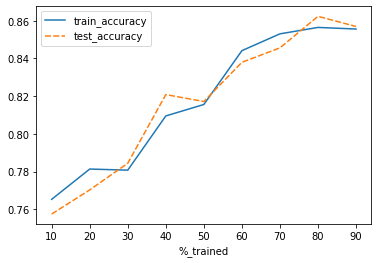

In [8]:
data_for_acc_vs_percentage_trained = {"%_trained":pc,
                                      "train_accuracy": train,
                                      "test_accuracy": test}
df = pd.DataFrame(data_for_acc_vs_percentage_trained).set_index("%_trained")
# df.head(10)
sns.lineplot(data=df)

## Method 2: Using streak length (pos + neg) as features

In [42]:
def get_streak_length(lab, percentage):
  lab_mice_in_training = behavior_analyses.SessionTrainingStatus & 'training_status = "in_training" ' & (subject.SubjectLab & 'lab_name = "{}"'.format(lab)) 
  lab_mice = np.unique(lab_mice_in_training.fetch('subject_uuid'))

  id = lab_mice_in_training.fetch('subject_uuid')
  training_days = np.zeros_like(lab_mice)

  for idx, mouse in enumerate(lab_mice):
    training_days[idx] = len(np.where(id == mouse)[0])

  dictionary = fetch_mice_by_percentage(lab_mice,lab_mice_in_training,percentage)
  # print(dictionary)

  X_0=[]
  X_1=[]
  X_2=[]

  y = []
  for mouse in lab_mice:
    try:
      for i in range(len(dictionary[mouse])):
        session, contrast_left, contrast_right = ((behavior.TrialSet.Trial & {'subject_uuid' : mouse} & {'trial_stim_prob_left': 0.5}) & {'session_start_time' : dictionary[mouse][i]}).fetch('trial_feedback_type',
        'trial_stim_contrast_left',
        'trial_stim_contrast_right')
        
        x_0 = contrast_left + contrast_right
        x_pos = [length_last_streak(session,j,1) for j in range(len(session))]
        x_neg = [length_last_streak(session,j,-1) for j in range(len(session))]

        X_0 = np.append(X_0,x_0)
        X_1 = np.append(X_1,x_pos)
        X_2 = np.append(X_2,x_neg)

        y = np.append(y,session)
    except:
      pass
  X = np.vstack((X_0,X_1,X_2))
  X = X.astype("float")
  y = y.astype("float")

  return (X, y)

In [105]:
X,y = get_streak_length("mainenlab", 20)
# print(X.shape,y.shape)
train_acc, test_acc, coef, roc = streak_modelling(X,y)

Training accuracy:53.36  Test accuracy:55.69
roc-auc score:0.56
Coefficients for logistic regression:
[ 0.0414307   0.07756401 -0.1988722 ]
TN:607 FP:1213 FN:395 TP:1414


In [106]:
pc=np.arange(10,100,10)
train=[]
test=[]
coef_contrast=[]
coef_pos_streak=[]
coef_neg_streak=[]
roc_list=[]
for percentage in pc:
    print("%_trained_mice_considered:{}".format(percentage))
    data_X, data_y = get_streak_length("mainenlab", percentage)
    train_acc, test_acc, coef, roc = streak_modelling(data_X, data_y)

    train.append(train_acc)
    test.append(test_acc)

    coef_contrast.append(coef[0])
    coef_pos_streak.append(coef[1])
    coef_neg_streak.append(coef[2])
    roc_list.append(roc)
    print("----")

%_trained_mice_considered:10
Training accuracy:51.10  Test accuracy:52.23
roc-auc score:0.53
Coefficients for logistic regression:
[-0.00432052 -0.02659777 -0.1649979 ]
TN:287 FP:530 FN:218 TP:531
----
%_trained_mice_considered:20
Training accuracy:53.36  Test accuracy:55.69
roc-auc score:0.56
Coefficients for logistic regression:
[ 0.0414307   0.07756401 -0.1988722 ]
TN:607 FP:1213 FN:395 TP:1414
----
%_trained_mice_considered:30
Training accuracy:56.17  Test accuracy:56.51
roc-auc score:0.55
Coefficients for logistic regression:
[ 0.00487946  0.19623909 -0.27534375]
TN:776 FP:848 FN:885 TP:1476
----
%_trained_mice_considered:40
Training accuracy:59.56  Test accuracy:58.67
roc-auc score:0.55
Coefficients for logistic regression:
[ 0.07517653  0.21317824 -0.23083865]
TN:992 FP:1228 FN:1457 TP:2819
----
%_trained_mice_considered:50
Training accuracy:57.84  Test accuracy:56.79
roc-auc score:0.55
Coefficients for logistic regression:
[ 0.15133952  0.21605251 -0.20850356]
TN:929 FP:880 FN:

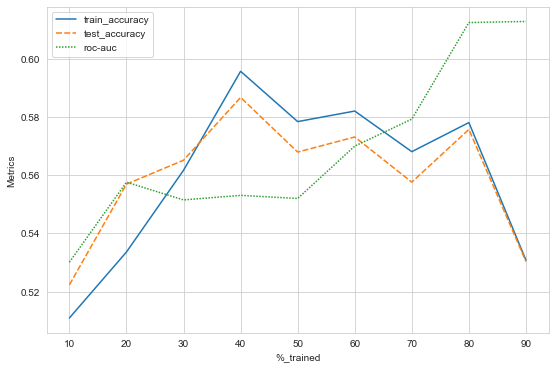

In [116]:
data_for_acc_vs_percentage_trained = {"%_trained":pc,
                                      "train_accuracy": train,
                                      "test_accuracy": test,
                                      "roc-auc": roc_list}
                                      
df = pd.DataFrame(data_for_acc_vs_percentage_trained).set_index("%_trained")

plt.figure(figsize=(9,6))
ax = sns.lineplot(data=df)
ax.set_ylabel("Metrics")
plt.savefig("./plots/acc_vs_percentage.png")
plt.show()

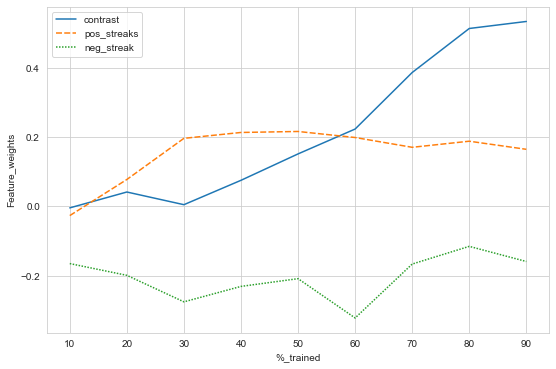

In [117]:
data_for_wts_vs_percentage_trained = {"%_trained":pc,
                                      "contrast": coef_contrast,
                                      "pos_streaks": coef_pos_streak,
                                      "neg_streak": coef_neg_streak}
                                      
df1 = pd.DataFrame(data_for_wts_vs_percentage_trained).set_index("%_trained")

plt.figure(figsize=(9,6))
ax = sns.lineplot(data=df1)
ax.set_ylabel("Feature_weights")
plt.savefig("./plots/weights_vs_percentage.png")
plt.show()